In [1]:
import seir_discrete 
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import tkinter as tk
from tkinter import messagebox
import math

In [2]:
def plot_one(ax, start_day, 
             modeled_days, seed_data, modeled_I, modeled_beta,
             seed, execution_time):
    '''
    Рисуем график для одного сида.
    '''
    
    actual_I = seed_data.iloc[start_day:]['I'].values 
    #n = len(modeled_I.shape[1])
    rmse_I = np.sqrt(mean_squared_error(actual_I, modeled_I[0]))

    actual_Beta = seed_data.iloc[start_day:]['Beta'].values 
    #n_beta = len(modeled_beta)
    rmse_Beta = np.sqrt(mean_squared_error(actual_Beta, modeled_beta))    

    # день перехода
    ax.axvline(start_day, ls=':')
    # реальные I, смоделированные I
    ax.plot(modeled_days, actual_I, color='tab:blue', label='Actual I')
    ax.plot(modeled_days, modeled_I[0],color='blue', ls='--', 
                alpha=0.8, label='Predicted I (det.)')
    # для стохастической С(И)ИР строим 15 траекторий
    for i in range(modeled_I.shape[0]-1):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
            
        ax.plot(modeled_days, modeled_I[i+1], color='tab:blue', ls='--', 
                alpha=0.3, label=label)
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # реальная beta, смоделированная beta
    ax_b.plot(seed_data.index, seed_data['Beta'],  color='gray', ls='--', alpha=0.1, label='Actual Beta')
    ax_b.plot(modeled_days, modeled_beta,color='coral', ls='--', alpha=0.3,label='Predicted Beta ')

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed}, \n'+
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Time: {execution_time:.2e}' ,fontsize=10)
    
def load_saved_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    return joblib.load(model_path)
    
def model_beta(beta_model, days):
    '''
    Моделируем/прогнозируем бету.
    '''
    
    if beta_model == 'exp_decay':
        # заглушка
        modeled_betas = [0 for i in days]
        
    elif beta_model == 'polynom':
        model_path = 'seir_model_barabasi-alber.joblib'
        # загрузка модели с функции ЭлизабЭтти
        model = load_saved_model(model_path)
        # прогнозируем бету на все оставшиеся дни
        log_beta = model.predict(days.reshape(-1,1))
        modeled_betas = np.exp(log_beta)
        
    elif beta_model == 'percentiles':
        # заглушка
        modeled_betas = [0 for i in days]
    
    return modeled_betas
        

def main_f(math_model, stochastic, count_stoch_line, beta_model, start_day, seed_numbers):
    '''
    Общая функция для построения графиков.
    
    Параметры:
    
    - math_model -- математическая модель для построения траектории Infected
        ['seir', 'sir']
    - stochastic -- присутствуют ли траектории стохастической модели СИИР 
        (траектории детерминированной присутствуют по умолчанию)
    - count_stoch_line -- количество траекторий стохастической модели СИИР
    - beta_model -- метод прогноза беты
        ['exp_decay', 'polynom', 'percentiles']
    - start_day -- день переключения на СИИР модель
    - seed_numbers -- номера сидов

    - seed_dirs -- путь к папке с сидами
    - seed_data -- датафрейм сида от регулярной сети

    - modeled_I -- смоделированная траектория компартмента Infected
    - modeled_days -- дни прогноза
    - modeled_beta -- смоделированная/спрогнозированная бета

    - ax -- область для графика

    
    Выход:
        График для сидов.
    '''
    # всегда постоянные
    sigma = 0.1
    gamma = 0.08
    
    fig, axes = plt.subplots(len(seed_numbers)//2+math.ceil(len(seed_numbers)%2), 2, figsize=(15, 15))
    axes = axes.flatten()
    
    seed_dirs=f'{math_model}_30_seeds_v0/'

    for idx, seed in enumerate(seed_numbers):
        
        # читаем данные сида: S,[E],I,R,Beta
        seed_data = pd.read_csv(seed_dirs + f'{math_model}_seed_{seed}.csv')
        seed_data = seed_data[pd.notna(seed_data['Beta'])]

        # дни для составления прогноза
        modeled_days = np.arange(start_day, seed_data.shape[0])
        
        # спрогнозированная бета
        start_time = time.time()
        modeled_beta = model_beta(beta_model, modeled_days)
        end_time = time.time()
        execution_time = end_time - start_time

        # берем значения компартментов в день переключения
        y = seed_data.iloc[start_day].drop('Beta')

        modeled_I = np.zeros((count_stoch_line+1, modeled_days.shape[0]))
        # передаем в соответствующую С(И)ИР модель (стохастическую или детерм.)
        # если math_model == ... , если stochastic == ...
        if math_model == 'seir':
             # пример для math_model='seir', stype='det'
            S,E,I,R = seir_discrete.seir_model(y, start_day, modeled_days, 
                                modeled_beta, sigma, gamma, 
                                stype='det', beta_t=True).T
            modeled_I[0] = I
            if stochastic:
                for i in range(count_stoch_line):
                    # пример для math_model='seir', stype='stochastic'
                    S,E,I,R = seir_discrete.seir_model(y, start_day, modeled_days, 
                                        modeled_beta, sigma, gamma, 
                                        stype='stoch', beta_t=True).T
                    
                    # для модели СИР будет: S,I,R = res.T
                    modeled_I[i+1] = I
        else:
            # пример для math_model='seir', stype='det'
            S,I,R = seir_discrete.sir_model(y, start_day, modeled_days, 
                                modeled_beta, gamma, 
                                stype='det', beta_t=True).T
            
            # для модели СИР будет: S,I,R = res.T
            modeled_I[0] = I
            if stochastic:    
                for i in range(count_stoch_line):
                    # пример для math_model='seir', stype='stochastic'
                    S,I,R = seir_discrete.sir_model(y, start_day, modeled_days, 
                                        modeled_beta, gamma, 
                                        stype='stoch', beta_t=True).T
                    
                    # для модели СИР будет: S,I,R = res.T
                    modeled_I[i+1] = I

        ax = axes[idx]
        # строим один график
        plot_one(ax, start_day, modeled_days, seed_data, modeled_I, modeled_beta, seed, execution_time)        
    
    plt.tight_layout()
    # Добавление общего заголовка
    fig.suptitle(f'Switch {start_day} day, \n'+
                 f'Math_model:{math_model}, \n'+
                 f'Beta_model: {beta_model}' ,fontsize=15)
    plt.show()

    
        

c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.2. This 

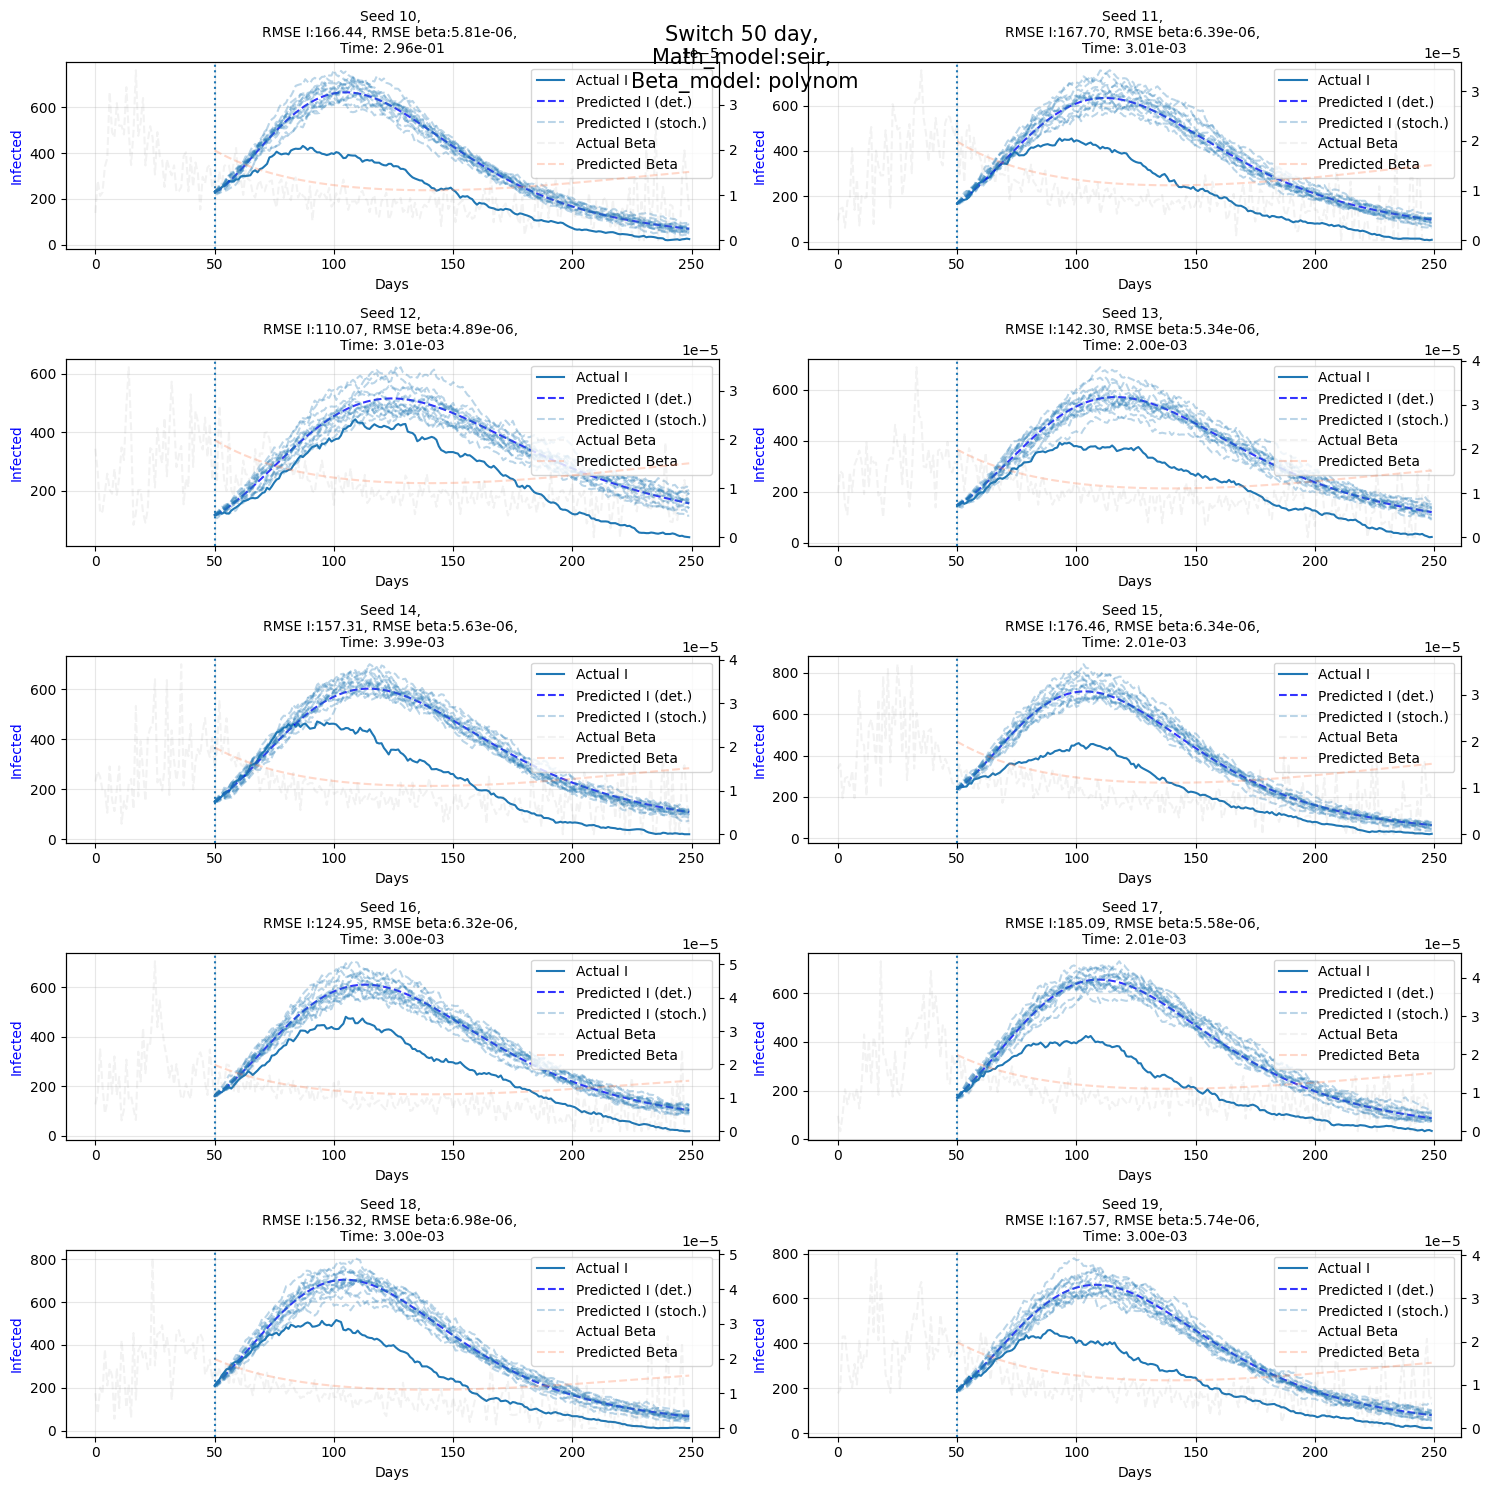

"    \n#Задаем параметры   \nstochastic=True\nstart_day=50 \nseeds = np.arange(10,20)   \nres = main_f('seir',stochastic, start_day, seeds)\n"

In [3]:
'''
создаем графическое окошко для ввода параметров
'''
def parse_seeds(seeds_input):
    seeds = set()  # Используем множество для уникальных значений
    parts = seeds_input.split(',')
    
    for part in parts:
        if '-' in part:  # Если есть тире, значит это диапазон
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # Добавляем все числа в диапазоне (включительно)
        else:
            seeds.add(int(part))  # Добавляем отдельное семя
            
    return sorted(seeds)  # Возвращаем отсортированный список

def calculate():
    try:
        # Получаем значения из полей ввода
        math_model = var_math_model.get()
        stochastic = var_stochastic.get()
        
        # Получаем количество случайных траекторий только если стохастичность включена
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0
        
        beta_model = var_beta_model.get()
        start_day = int(entry_start_day.get())
        seed_numbers = entry_seed_numbers.get()

        # Парсим семена
        seed_numbers = parse_seeds(seed_numbers)
        
        # Вызываем основную функцию
        result = main_f(math_model, stochastic, count_stoch_line, beta_model, start_day, seed_numbers)
        
        # Выводим результат
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

# Создаем главное окно
root = tk.Tk()
root.title("Ввод параметров")

# Создаем переменную для выбора мат. модели
var_math_model = tk.StringVar(value="seir")  # Устанавливаем значение по умолчанию

# Создаем выпадающий список для выбора мат. модели
label_math_model = tk.Label(root, text="Тип математической модели:")
label_math_model.pack()

math_model_options = ["seir", "sir"]
dropdown_math_model = tk.OptionMenu(root, var_math_model, *math_model_options)
dropdown_math_model.pack()

# Создаем флажок для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", variable=var_stochastic, command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# Создаем метку и поле ввода для count_stoch_line
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()

entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # Изначально отключаем поле ввода

# Функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # Включаем поле ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # Отключаем поле ввода

# Создаем переменную для выбора модели прогнозирования beta
var_beta_model = tk.StringVar(value="polynom")  # Устанавливаем значение по умолчанию

# Создаем выпадающий список для выбора мат. модели
label_beta_model = tk.Label(root, text="Тип модели для прогнозирования beta:")
label_beta_model.pack()

beta_model_options = ['polynom', 'exp_decay', 'percentiles']
dropdown_beta_model = tk.OptionMenu(root, var_beta_model, *beta_model_options)
dropdown_beta_model.pack()

# Создаем метку и поле ввода для start_day
label_start_day = tk.Label(root, text="День начала:")
label_start_day.pack()

entry_start_day = tk.Entry(root)
entry_start_day.pack()

# Создаем метку и поле ввода для seeds
label_seed_numbers = tk.Label(root, text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()

entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# Создаем кнопку для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack()

# Запускаем главный цикл приложения
root.mainloop()

'''    
#Задаем параметры   
stochastic=True
start_day=50 
seeds = np.arange(10,20)   
res = main_f('seir',stochastic, start_day, seeds)
'''